In [1]:
#reference https://www.kaggle.com/c/trackml-particle-identification/discussion/57643

import os
from trackml.score  import score_event
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares


particle id:4504836577951744
763.3058215091359 -797.1618930424663 1103.4098911450951 0.0734989191630684 1.9801597589862594e-06 0.7165217759504358
763.3058215091359 -797.1618930424663 1103.4098911450951 0.07349891912913847 1.9801598056122857e-06 0.7165217777846284


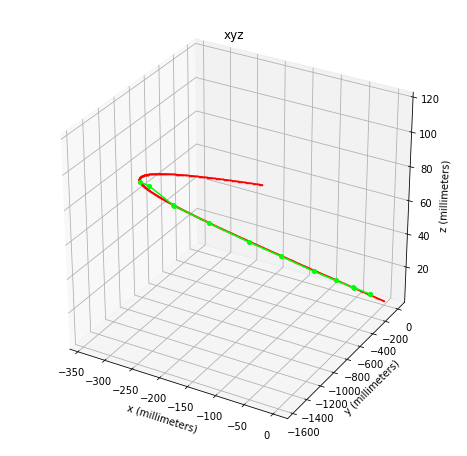

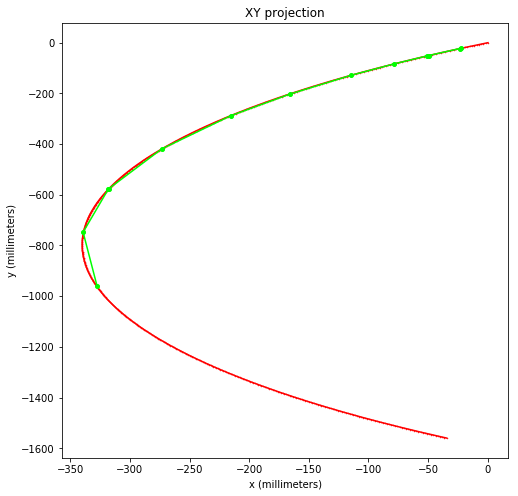

In [14]:
# estimate helix paramater space
def helix_estimate_param_from_track(xyz):
    
    def residuals_xy(param, x, y):
        x0, y0 = param
        r = np.sqrt((x-x0)**2 + (y-y0)**2)
        d = r - r.mean()
        return d
    
    def residuals_z(param, r, z):
        m2,m1,m0 = param
        zz = m2*r**2 + m1*r + m0
        d = z - zz
        return d
    
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    
    param0 = (x.mean(), y.mean())
    res_lsq = least_squares(residuals_xy, param0, loss='soft_l1', f_scale=1.0, args=(x,y))
    x0,y0 = res_lsq.x
    r0 = np.sqrt((x-x0)**2 + (y-y0)**2).mean()
    r = np.sqrt(x**2 + y**2)
    
    if 1:
        param0 = (0,0,0)
        res_lsq = least_squares(residuals_z, param0, args=(r, z))
        m2, m1, m0 = res_lsq.x
        print(x0,y0,r0,m1,m2,m0)
        
    if 1:
        m2,m1,m0 = np.polyfit(r,z,2)
        print(x0,y0,r0,m1,m2,m0)
        
    param = (x0,y0,r0,m1,m2,m0)
    return param

# convert x,y,z to curve space
def helix_search_theta(xyz, param, S=2.5):
    
    x0, y0, r0, m2, m1, m0 = param
    theta0 = np.arctan2(y0, x0)
    #sort by z
    xyz = xyz[np.argsort(np.fabs(xyz[:,2]))]
    xx = xyz[:,0] - x0
    yy = xyz[:,1] - y0
    x = xx*np.cos(-theta0) - yy*np.sin(-theta0)
    y = xx*np.sin(-theta0) + yy*np.cos(-theta0)
    theta = np.arctan(y, -x)
    
    theta_min = 0
    theta_max = theta[-1]
    theta_num = S*len(xyz)*50
    return np.linspace(theta_min, theta_max, theta_num)
    

def helix_generate_track_from_param(param, theta=np.linspace(0, 2*np.pi, 360)):
    x0, y0, r0, m1, m2, m0 = param
    theta0 = np.arctan2(y0, x0)
    xx = -r0*np.cos(theta)
    yy = r0*np.sin(theta)
    x = xx*np.cos(theta0) - yy*np.sin(theta0)+x0
    y = xx*np.sin(theta0) + yy*np.cos(theta0)+y0
    
    r = np.sqrt(x**2 + y**2)
    z = m2*r**2 + m1*r + m0
    
    xyz = np.column_stack([x,y,z])
    return xyz

def study_helix_param():
    # Change this from 0 - 83xx :number of particles
    track_id = 9
     ## load an event ---
    event_id = '1003'

    data_dir  = '../../../input/train_100_events'
    csv_dir = '../../../input/'
    
    particles = pd.read_csv(os.path.join(data_dir, 'event00000%s-particles.csv'%event_id))
    hits      = pd.read_csv(os.path.join(data_dir, 'event00000%s-hits.csv' %event_id))
    truth     = pd.read_csv(os.path.join(data_dir, 'event00000%s-truth.csv'%event_id))
    
    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')
    
    #--------------------------------------------------------
    df = truth.copy()
    p = df[['particle_id']].values.astype(np.int64)
    particle_ids = np.unique(p)
    particle_ids = particle_ids[particle_ids!=0]

    print('particle id:'+ str(particle_ids[track_id]))
    t = df.loc[(df.particle_id==particle_ids[track_id])].as_matrix(columns=['x','y','z'])
    param = helix_estimate_param_from_track(t)
    theta = helix_search_theta(t, param, S=1)
    
    ## Visualization only 
    helix = helix_generate_track_from_param(param, theta=theta)
    
    fig1 = plt.figure(figsize=(8, 8))
    ax1 = fig1.add_subplot(111, projection='3d')

    ax1.plot(helix[:,0], helix[:,1], helix[:,2], '.-', color=[1,0,0], markersize=1)
    # ground truth
    ax1.plot(t[:,0], t[:,1], t[:,2], '.-', color=[0,1,0], markersize=8)
    ax1.set_title('xyz')
    ax1.set_xlabel('x (millimeters)')
    ax1.set_ylabel('y (millimeters)')
    ax1.set_zlabel('z (millimeters)')
    
    fig2 = plt.figure(figsize=(8, 8))
    ax2 = fig2.add_subplot(111)
    
    ax2.plot(helix[:,0], helix[:,1], '.-', color=[1,0,0], markersize=1)
    # ground truth
    ax2.plot(t[:,0], t[:,1], '.-', color=[0,1,0], markersize=8)
    
    ax2.set_title('XY projection')
    ax2.set_xlabel('x (millimeters)')
    ax2.set_ylabel('y (millimeters)')
    

if __name__ == '__main__':
    
    study_helix_param()
